# Trying to find the correct metric for SOP and AOP

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as F
from utils.utils_analyze import topk_entropy, top12_prob_diff,get_label_rank_practical
from tqdm import tqdm
import seaborn as sns
from utils.config_read import *
import math
sns.set_theme()

def standard_score(tensor):
    mean = tensor.float().mean()
    std = tensor.float().std()
    return (tensor - mean) / std

In [2]:
config = load_config("./configs/train_basic.yaml")
MODEL_name = "Qwen/Qwen2.5-7B-Instruct" #"Qwen/Qwen2.5-Math-7B-Instruct" #"microsoft/Phi-3-mini-4k-instruct" #"mistralai/Mistral-7B-v0.1" #"deepseek-ai/deepseek-llm-7b-chat" #
#"Qwen/Qwen2.5-0.5B" #"Qwen/Qwen2.5-Math-1.5B" #  
MODEL = MODEL_name.split('/')[-1]
SCRATCH_PATH = f'/scratch/joshua52/sft_rl_temp/{MODEL}/'
RANK_MAX = 1000
print(f'Model is {MODEL}')

Model is Qwen2.5-7B-Instruct


## Scatter plot check of different metrics

In [3]:
def get_stats(loaded_data, loaded_label):
    N_sample = len(loaded_data)
    results = {}
    entropy_list = []
    yprob_list = []
    prefix_list = []
    rank_list = []
    for i in tqdm(range(N_sample)):
        logits = loaded_data[i]
        labels = loaded_label[i]
        probs = F.softmax(logits, dim=-1)  # [L, V]
        entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)  # [L]
        entropy_list.append(entropy)
    
        diff, top1_prob, top2_prob, yprob = top12_prob_diff(logits, labels)
        yprob_list.append(yprob)
        prefix = [yprob.mean()]
        for j in range(yprob.shape[0]-1):
            prefix.append(yprob[:j+1].sum() / (j+1))
        prefix_list.append(torch.tensor(prefix))
        
        rank = get_label_rank_practical(logits, labels, max_rank_to_compute=RANK_MAX)
        rank_list.append(rank)
    entropy_all = torch.cat(entropy_list,dim=0)
    yprob_all = torch.cat(yprob_list,dim=0)
    prefix_all = torch.cat(prefix_list,dim=0)
    rank_all = torch.cat(rank_list,dim=0)
    
    results['entropy'] = entropy_all
    results['yprob'] = yprob_all
    results['prefix'] = prefix_all
    results['rank'] = rank_all
    return results

In [4]:
EXP_NAME = 'sft' #'rl_tmp1'#
SFT_OR_RL = EXP_NAME.split('_')[0]
raw_data = torch.load(f'{SCRATCH_PATH}{EXP_NAME}_logits.pt')
loaded_data = raw_data[f'{SFT_OR_RL}_logits']
loaded_label = raw_data[f'{SFT_OR_RL}_labels']

sft_results = get_stats(loaded_data, loaded_label)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.34it/s]


In [5]:
EXP_NAME = 'rl_tmp1'
SFT_OR_RL = EXP_NAME.split('_')[0]
raw_data = torch.load(f'{SCRATCH_PATH}{EXP_NAME}_logits.pt')
loaded_data = raw_data[f'{SFT_OR_RL}_logits']
loaded_label = raw_data[f'{SFT_OR_RL}_labels']

rl_tmp1_results = get_stats(loaded_data, loaded_label)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.27it/s]


Text(0, 0.5, 'entropy')

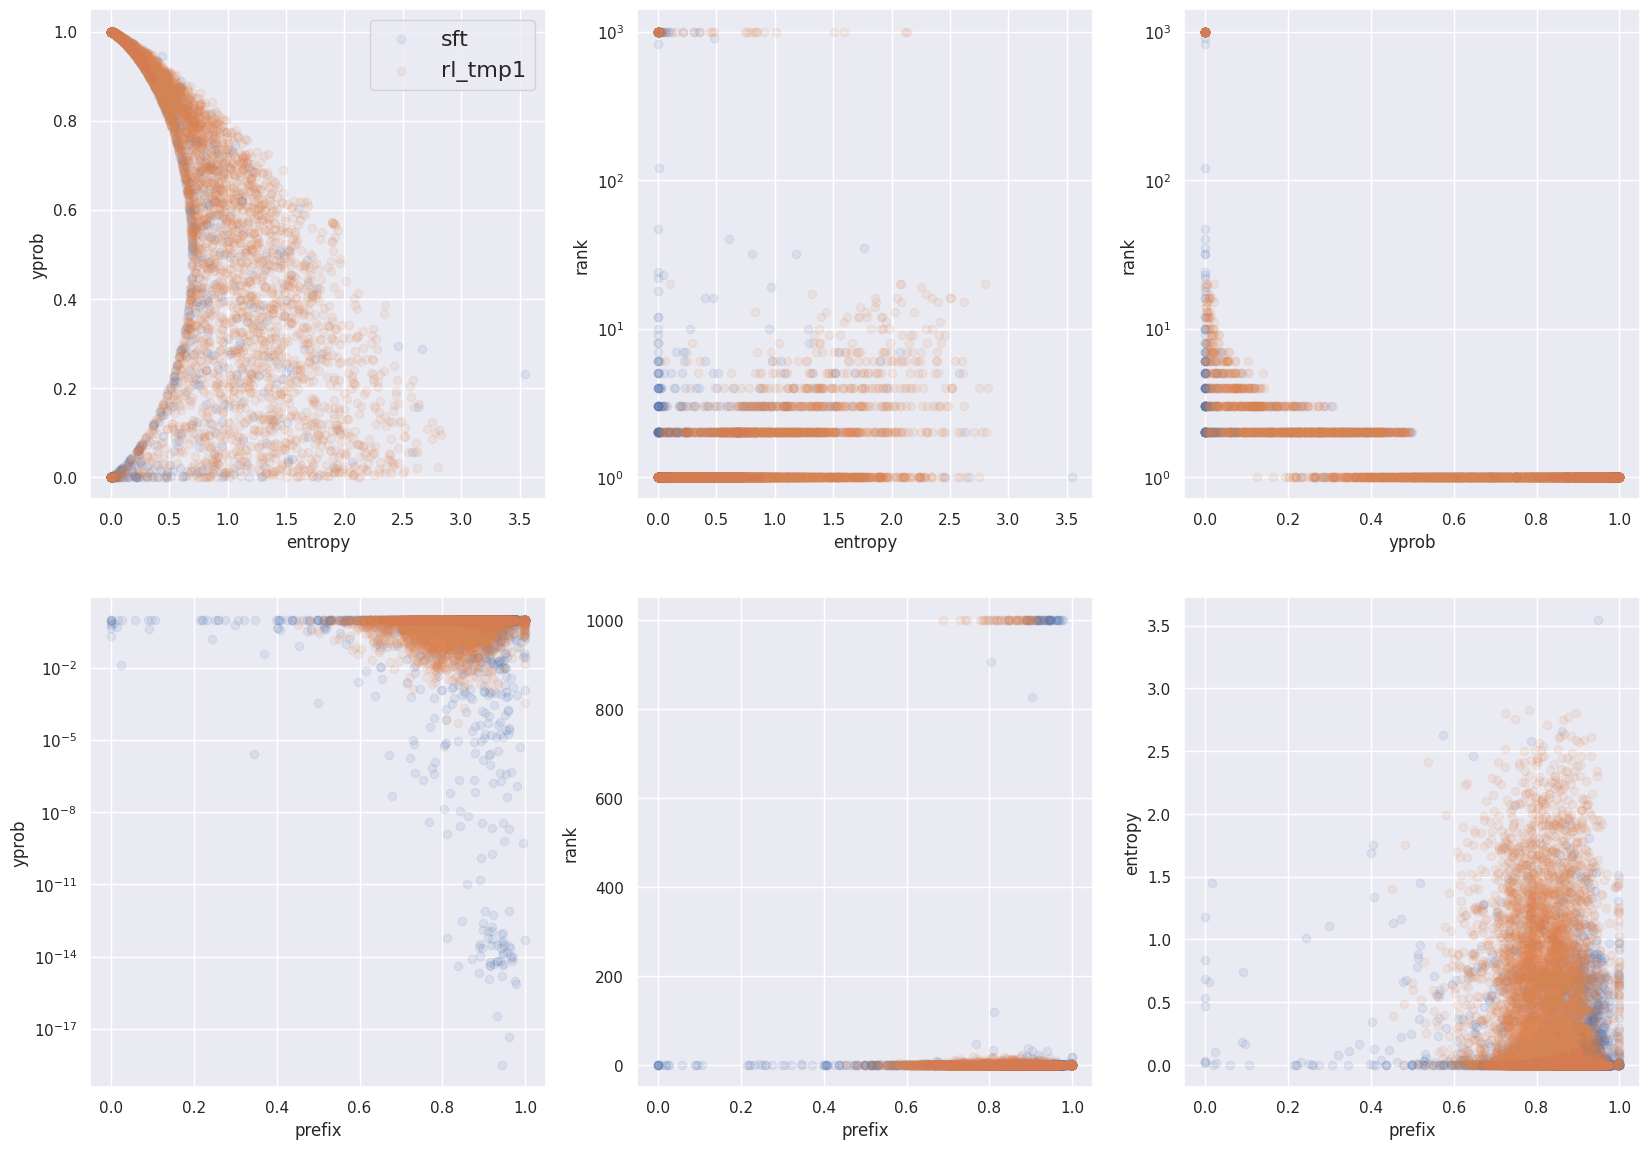

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(20, 14))
XY = ('entropy', 'yprob')
ax[0][0].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1,label='sft')
ax[0][0].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1,label='rl_tmp1')
ax[0][0].set_xlabel(XY[0])
ax[0][0].set_ylabel(XY[1])
ax[0][0].legend(fontsize=16)
#ax[0][0].set_yscale('log')

XY = ('entropy', 'rank')
ax[0][1].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[0][1].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[0][1].set_xlabel(XY[0])
ax[0][1].set_ylabel(XY[1])
ax[0][1].set_yscale('log')

XY = ('yprob', 'rank')
ax[0][2].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[0][2].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[0][2].set_xlabel(XY[0])
ax[0][2].set_ylabel(XY[1])
ax[0][2].set_yscale('log')

XY = ('prefix', 'yprob')
ax[1][0].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[1][0].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[1][0].set_xlabel(XY[0])
ax[1][0].set_ylabel(XY[1])
ax[1][0].set_yscale('log')

XY = ('prefix', 'rank')
ax[1][1].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[1][1].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[1][1].set_xlabel(XY[0])
ax[1][1].set_ylabel(XY[1])
#ax[1][1].set_yscale('log')

XY = ('prefix', 'entropy')
ax[1][2].scatter(sft_results[XY[0]], sft_results[XY[1]], alpha=0.1)
ax[1][2].scatter(rl_tmp1_results[XY[0]], rl_tmp1_results[XY[1]], alpha=0.1)
ax[1][2].set_xlabel(XY[0])
ax[1][2].set_ylabel(XY[1])

## Print out those very low-yprob tokens

In [7]:
from IPython.display import display, HTML
import torch
def visualize_tokens_final(tokenizer, labels, probs, threshold=0.5,base_color=(255,0,0)):
    # 1. 确保是 List
    if torch.is_tensor(labels): labels = labels.detach().cpu().tolist()
    if torch.is_tensor(probs): probs = probs.detach().cpu().tolist()

    # 2. 获取 Tokens
    tokens = tokenizer.convert_ids_to_tokens(labels)
    
    html_elements = []
    
    for token, prob in zip(tokens, probs):
        # --- 核心改进：使用 tokenizer 自己的转换逻辑 ---
        # convert_tokens_to_string 会把 'Ġ' 变成 ' '，把 'Ċ' 变成 '\n'
        display_text = tokenizer.convert_tokens_to_string([token])
        
        # 为了 HTML 正常显示换行，我们需要手动把 '\n' 换成 '<br/>'
        display_text = display_text.replace('\n', '<br/>')
        
        # 处理空格：HTML 连续空格会塌陷，这里可以根据需要处理
        # 但通常 white-space: pre-wrap 就能解决
        base_r, base_g, base_b = base_color
        if prob < threshold:
            # 颜色渐变逻辑
            alpha = 0.1 + (max(0, threshold - prob) / threshold) * 0.7
            style = (
                f"background-color: rgba({base_r}, {base_g}, {base_b}, {alpha:.2f}); "
                f"border-bottom: 2px solid rgba({base_r}, {base_g}, {base_b}, {alpha + 0.2:.2f}); "
                f"border-radius: 2px; "
            )
            html_elements.append(f'<span style="{style}" title="Prob: {prob:.3e}">{display_text}</span>')
        else:
            html_elements.append(f'<span>{display_text}</span>')
    
    # 3. 渲染
    display(HTML(f"""
        <div style="
            font-family: 'Segoe UI', 'Roboto', monospace; 
            line-height: 1.6; 
            padding: 15px; 
            background: #fff;
            white-space: pre-wrap;
            word-wrap: break-word;
            border: 1px solid #ddd;
            border-radius: 5px;
        ">{''.join(html_elements)}</div>
    """))



In [8]:
from transformers import AutoTokenizer
THRES = 1e-2

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_name,
    padding_side="right",
    truncation_side="right",
    trust_remote_code=True,
    #use_fast=False 
)

/scratch/joshua52/env_trl/lib/python3.11/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [9]:
EXP_NAME = 'sft' #'rl_tmp1'#
SFT_OR_RL = EXP_NAME.split('_')[0]
raw_data = torch.load(f'{SCRATCH_PATH}{EXP_NAME}_logits.pt')
loaded_data = raw_data[f'{SFT_OR_RL}_logits']
loaded_label = raw_data[f'{SFT_OR_RL}_labels']

N_sample = len(loaded_data)
results = {}
yprob_list = []
prefix_list = []
for i in range(50):
    logits = loaded_data[i]
    labels = loaded_label[i]
    probs = F.softmax(logits, dim=-1)  # [L, V]
    diff, top1_prob, top2_prob, yprob = top12_prob_diff(logits, labels)
    yprob_list.append(yprob)
    prefix = [yprob.mean()]
    for j in range(yprob.shape[0]-1):
        prefix.append(yprob[:j+1].sum() / (j+1))
    prefix_list.append(torch.tensor(prefix))

    # ------- Record low y_prob tokens 
    print(f"============= The {i}-th Example ===============")
    print(visualize_tokens_final(tokenizer, labels, yprob, THRES, base_color=(255,0,0)))

============= The 0-th Example ===============


None
============= The 1-th Example ===============


None
============= The 2-th Example ===============


None
============= The 3-th Example ===============


None
============= The 4-th Example ===============


None
============= The 5-th Example ===============


None
============= The 6-th Example ===============


None
============= The 7-th Example ===============


None
============= The 8-th Example ===============


None
============= The 9-th Example ===============


None
============= The 10-th Example ===============


None
============= The 11-th Example ===============


None
============= The 12-th Example ===============


None
============= The 13-th Example ===============


None
============= The 14-th Example ===============


None
============= The 15-th Example ===============


None
============= The 16-th Example ===============


None
============= The 17-th Example ===============


None
============= The 18-th Example ===============


None
============= The 19-th Example ===============


None
============= The 20-th Example ===============


None
============= The 21-th Example ===============


None
============= The 22-th Example ===============


None
============= The 23-th Example ===============


None
============= The 24-th Example ===============


None
============= The 25-th Example ===============


None
============= The 26-th Example ===============


None
============= The 27-th Example ===============


None
============= The 28-th Example ===============


None
============= The 29-th Example ===============


None
============= The 30-th Example ===============


None
============= The 31-th Example ===============


None
============= The 32-th Example ===============


None
============= The 33-th Example ===============


None
============= The 34-th Example ===============


None
============= The 35-th Example ===============


None
============= The 36-th Example ===============


None
============= The 37-th Example ===============


None
============= The 38-th Example ===============


None
============= The 39-th Example ===============


None
============= The 40-th Example ===============


None
============= The 41-th Example ===============


None
============= The 42-th Example ===============


None
============= The 43-th Example ===============


None
============= The 44-th Example ===============


None
============= The 45-th Example ===============


None
============= The 46-th Example ===============


None
============= The 47-th Example ===============


None
============= The 48-th Example ===============


None
============= The 49-th Example ===============


None


In [12]:
EXP_NAME = 'rl_tmp1'#'sft' #
SFT_OR_RL = EXP_NAME.split('_')[0]
raw_data = torch.load(f'{SCRATCH_PATH}{EXP_NAME}_logits.pt')
loaded_data = raw_data[f'{SFT_OR_RL}_logits']
loaded_label = raw_data[f'{SFT_OR_RL}_labels']

N_sample = len(loaded_data)
results = {}
yprob_list = []
prefix_list = []
for i in range(50):
    logits = loaded_data[i]
    labels = loaded_label[i]
    probs = F.softmax(logits, dim=-1)  # [L, V]
    diff, top1_prob, top2_prob, yprob = top12_prob_diff(logits, labels)
    yprob_list.append(yprob)
    prefix = [yprob.mean()]
    for j in range(yprob.shape[0]-1):
        prefix.append(yprob[:j+1].sum() / (j+1))
    prefix_list.append(torch.tensor(prefix))

    # ------- Record low y_prob tokens 
    print(f"============= The {i}-th Example ===============")
    print(visualize_tokens_final(tokenizer, labels, yprob, THRES, base_color=(255,0,0)))

============= The 0-th Example ===============


None
============= The 1-th Example ===============


None
============= The 2-th Example ===============


None
============= The 3-th Example ===============


None
============= The 4-th Example ===============


None
============= The 5-th Example ===============


None
============= The 6-th Example ===============


None
============= The 7-th Example ===============


None
============= The 8-th Example ===============


None
============= The 9-th Example ===============


None
============= The 10-th Example ===============


None
============= The 11-th Example ===============


None
============= The 12-th Example ===============


None
============= The 13-th Example ===============


None
============= The 14-th Example ===============


None
============= The 15-th Example ===============


None
============= The 16-th Example ===============


None
============= The 17-th Example ===============


None
============= The 18-th Example ===============


None
============= The 19-th Example ===============


None
============= The 20-th Example ===============


None
============= The 21-th Example ===============


None
============= The 22-th Example ===============


None
============= The 23-th Example ===============


None
============= The 24-th Example ===============


None
============= The 25-th Example ===============


None
============= The 26-th Example ===============


None
============= The 27-th Example ===============


None
============= The 28-th Example ===============


None
============= The 29-th Example ===============


None
============= The 30-th Example ===============


None
============= The 31-th Example ===============


None
============= The 32-th Example ===============


None
============= The 33-th Example ===============


None
============= The 34-th Example ===============


None
============= The 35-th Example ===============


None
============= The 36-th Example ===============


None
============= The 37-th Example ===============


None
============= The 38-th Example ===============


None
============= The 39-th Example ===============


None
============= The 40-th Example ===============


None
============= The 41-th Example ===============


None
============= The 42-th Example ===============


None
============= The 43-th Example ===============


None
============= The 44-th Example ===============


None
============= The 45-th Example ===============


None
============= The 46-th Example ===============


None
============= The 47-th Example ===============


None
============= The 48-th Example ===============


None
============= The 49-th Example ===============


None
